<h1>
 PREDICCIÓN DE MÉTODO ANTICONCEPTIVO MEDIANTE ÁRBOL DE DECISIÓN.

<hr>

# Descripción del problema:

EL conjunto de datos es un subconjunto de la Encuesta nacional de prevalencia de
anticonceptivos de Indonesia de 1987. Las muestras son mujeres casadas que no estaban
embarazadas o no saben si estaban en el momento de la entrevista. El problema es predecir
la elección actual del método anticonceptivo (sin uso, métodos a largo plazo o métodos a
corto plazo) de una mujer en función de sus características demográficas y socioeconómicas.


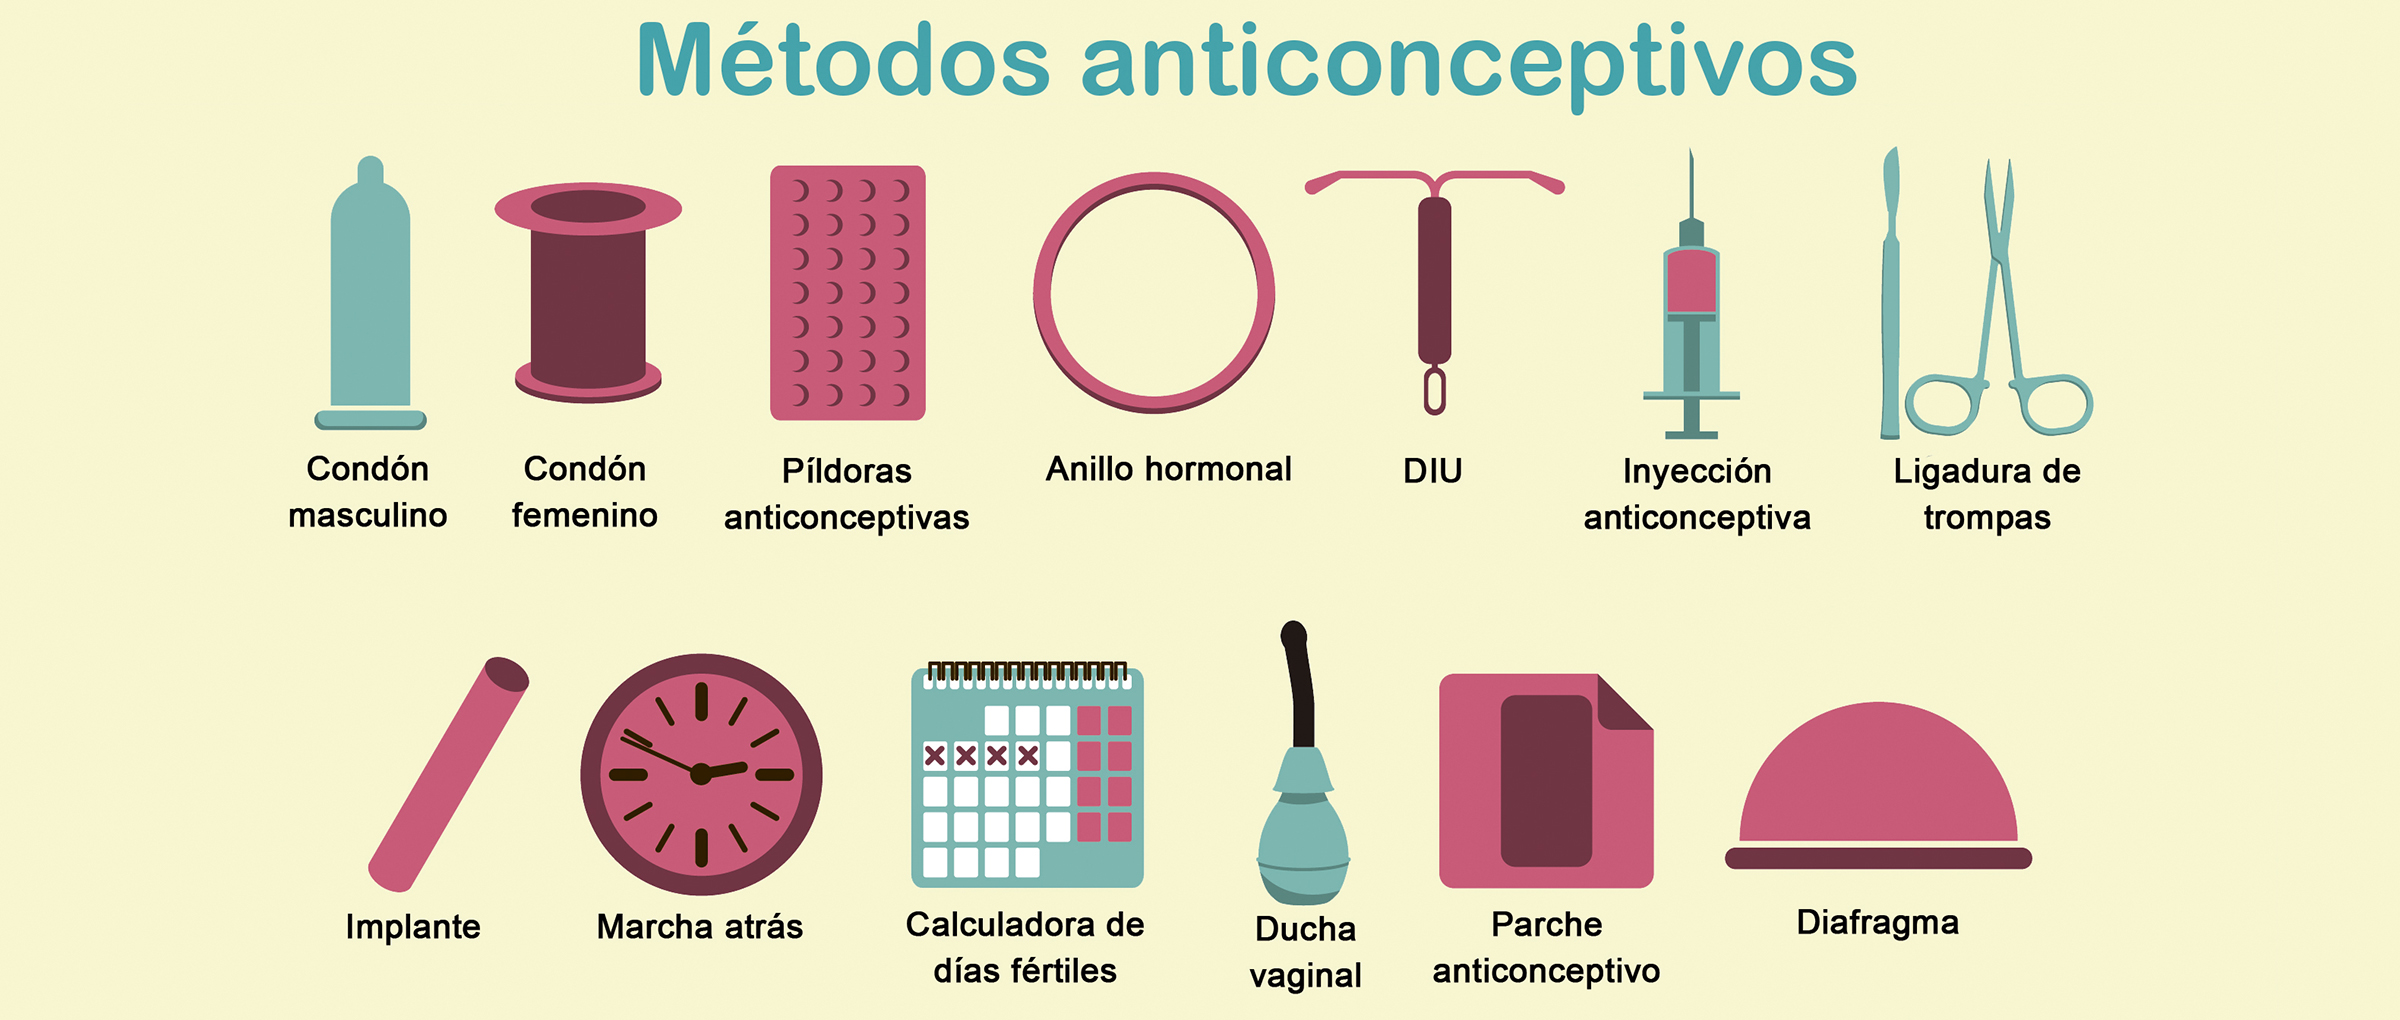

# Librerías

In [1]:
# Imports necesarios
import numpy as np
import pandas as pd
import seaborn as sb
import io

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont

# Cargar Datos

In [2]:
anticonceptivo = pd.read_csv(r"anticonceptivo.csv") 

In [3]:
anticonceptivo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1473 entries, 0 to 1472
Data columns (total 10 columns):
 #   Column                                   Non-Null Count  Dtype
---  ------                                   --------------  -----
 0   Edad de la esposa                        1473 non-null   int64
 1   Educación de la esposa                   1473 non-null   int64
 2   Educación del esposo                     1473 non-null   int64
 3   Número de hijos nacidos                  1473 non-null   int64
 4   Religión de la esposa                    1473 non-null   int64
 5   ¿La esposa ahora está trabajando?        1473 non-null   int64
 6   Ocupación del esposo                     1473 non-null   int64
 7   Índice de nivel de vida                  1473 non-null   int64
 8   Exposición a los medios anticonceptivos  1473 non-null   int64
 9   Método anticonceptivo utilizado          1473 non-null   int64
dtypes: int64(10)
memory usage: 115.2 KB


In [4]:
# Cambiar a la primer posición la variable objetivo
anticonceptivo = anticonceptivo[["Método anticonceptivo utilizado","Edad de la esposa","Educación de la esposa","Educación del esposo",
                                                    "Número de hijos nacidos","Religión de la esposa","¿La esposa ahora está trabajando?",
                                                    "Ocupación del esposo","Índice de nivel de vida","Exposición a los medios anticonceptivos"]] 

In [5]:
# los valores del método anticonceptivo usado están entre 1 y 3 , se cambia a valores entre 0 y 2 para obtener los resultados en las predicciones
for i in range (len(anticonceptivo["Método anticonceptivo utilizado"])):
  anticonceptivo["Método anticonceptivo utilizado"][i] -=1

In [6]:
anticonceptivo.head(10)

,Método anticonceptivo utilizado,Edad de la esposa,Educación de la esposa,Educación del esposo,Número de hijos nacidos,Religión de la esposa,¿La esposa ahora está trabajando?,Ocupación del esposo,Índice de nivel de vida,Exposición a los medios anticonceptivos
0,0,24,2,3,3,1,1,2,3,0
1,0,45,1,3,10,1,1,3,4,0
2,0,43,2,3,7,1,1,3,4,0
3,0,42,3,2,9,1,1,3,3,0
4,0,36,3,3,8,1,1,3,2,0
5,0,19,4,4,0,1,1,3,3,0
6,0,38,2,3,6,1,1,3,2,0
7,0,21,3,3,1,1,0,3,2,0
8,0,27,2,3,3,1,1,3,4,0
9,0,45,1,1,8,1,1,2,2,1


Todos los datos son de tipo entero y no se observan casillas nulas en el dataset, por lo cual se simplifica bastante el preprocesamiento

# Ver las estadísticas principales

In [7]:
anticonceptivo.describe(include='all').transpose()

,count,mean,std,min,25%,50%,75%,max
Método anticonceptivo utilizado,1473.0,0.919891,0.876376,0.0,0.0,1.0,2.0,2.0
Edad de la esposa,1473.0,32.538357,8.227245,16.0,26.0,32.0,39.0,49.0
Educación de la esposa,1473.0,2.958588,1.014994,1.0,2.0,3.0,4.0,4.0
Educación del esposo,1473.0,3.429735,0.816349,1.0,3.0,4.0,4.0,4.0
Número de hijos nacidos,1473.0,3.261371,2.358549,0.0,1.0,3.0,4.0,16.0
Religión de la esposa,1473.0,0.850645,0.356559,0.0,1.0,1.0,1.0,1.0
¿La esposa ahora está trabajando?,1473.0,0.749491,0.433453,0.0,0.0,1.0,1.0,1.0
Ocupación del esposo,1473.0,2.137814,0.864857,1.0,1.0,2.0,3.0,4.0
Índice de nivel de vida,1473.0,3.133741,0.976161,1.0,3.0,3.0,4.0,4.0
Exposición a los medios anticonceptivos,1473.0,0.073999,0.261858,0.0,0.0,0.0,0.0,1.0


# Comportamiento de los atributos

In [8]:
for i in anticonceptivo:
    print(anticonceptivo.groupby(i).size(), '\n') 

Método anticonceptivo utilizado
0    629
1    333
2    511
dtype: int64 

Edad de la esposa
16     3
17     8
18     7
19    18
20    28
21    48
22    59
23    44
24    61
25    80
26    69
27    59
28    63
29    59
30    64
31    46
32    64
33    55
34    50
35    62
36    57
37    51
38    44
39    34
40    34
41    34
42    40
43    34
44    39
45    41
46    22
47    43
48    30
49    23
dtype: int64 

Educación de la esposa
1    152
2    334
3    410
4    577
dtype: int64 

Educación del esposo
1     44
2    178
3    352
4    899
dtype: int64 

Número de hijos nacidos
0      97
1     276
2     276
3     259
4     197
5     135
6      92
7      49
8      47
9      16
10     11
11     11
12      4
13      2
16      1
dtype: int64 

Religión de la esposa
0     220
1    1253
dtype: int64 

¿La esposa ahora está trabajando?
0     369
1    1104
dtype: int64 

Ocupación del esposo
1    436
2    425
3    585
4     27
dtype: int64 

Índice de nivel de vida
1    129
2    229
3    431
4  

# ver la información en diagramas de barras

Diagrama de barras para todas las variables

















C:\Users\js-mu\anaconda3\envs\Tecnia\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\js-mu\anaconda3\envs\Tecnia\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\js-mu\anaconda3\envs\Tecnia\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarnin

C:\Users\js-mu\anaconda3\envs\Tecnia\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\js-mu\anaconda3\envs\Tecnia\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\js-mu\anaconda3\envs\Tecnia\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarnin

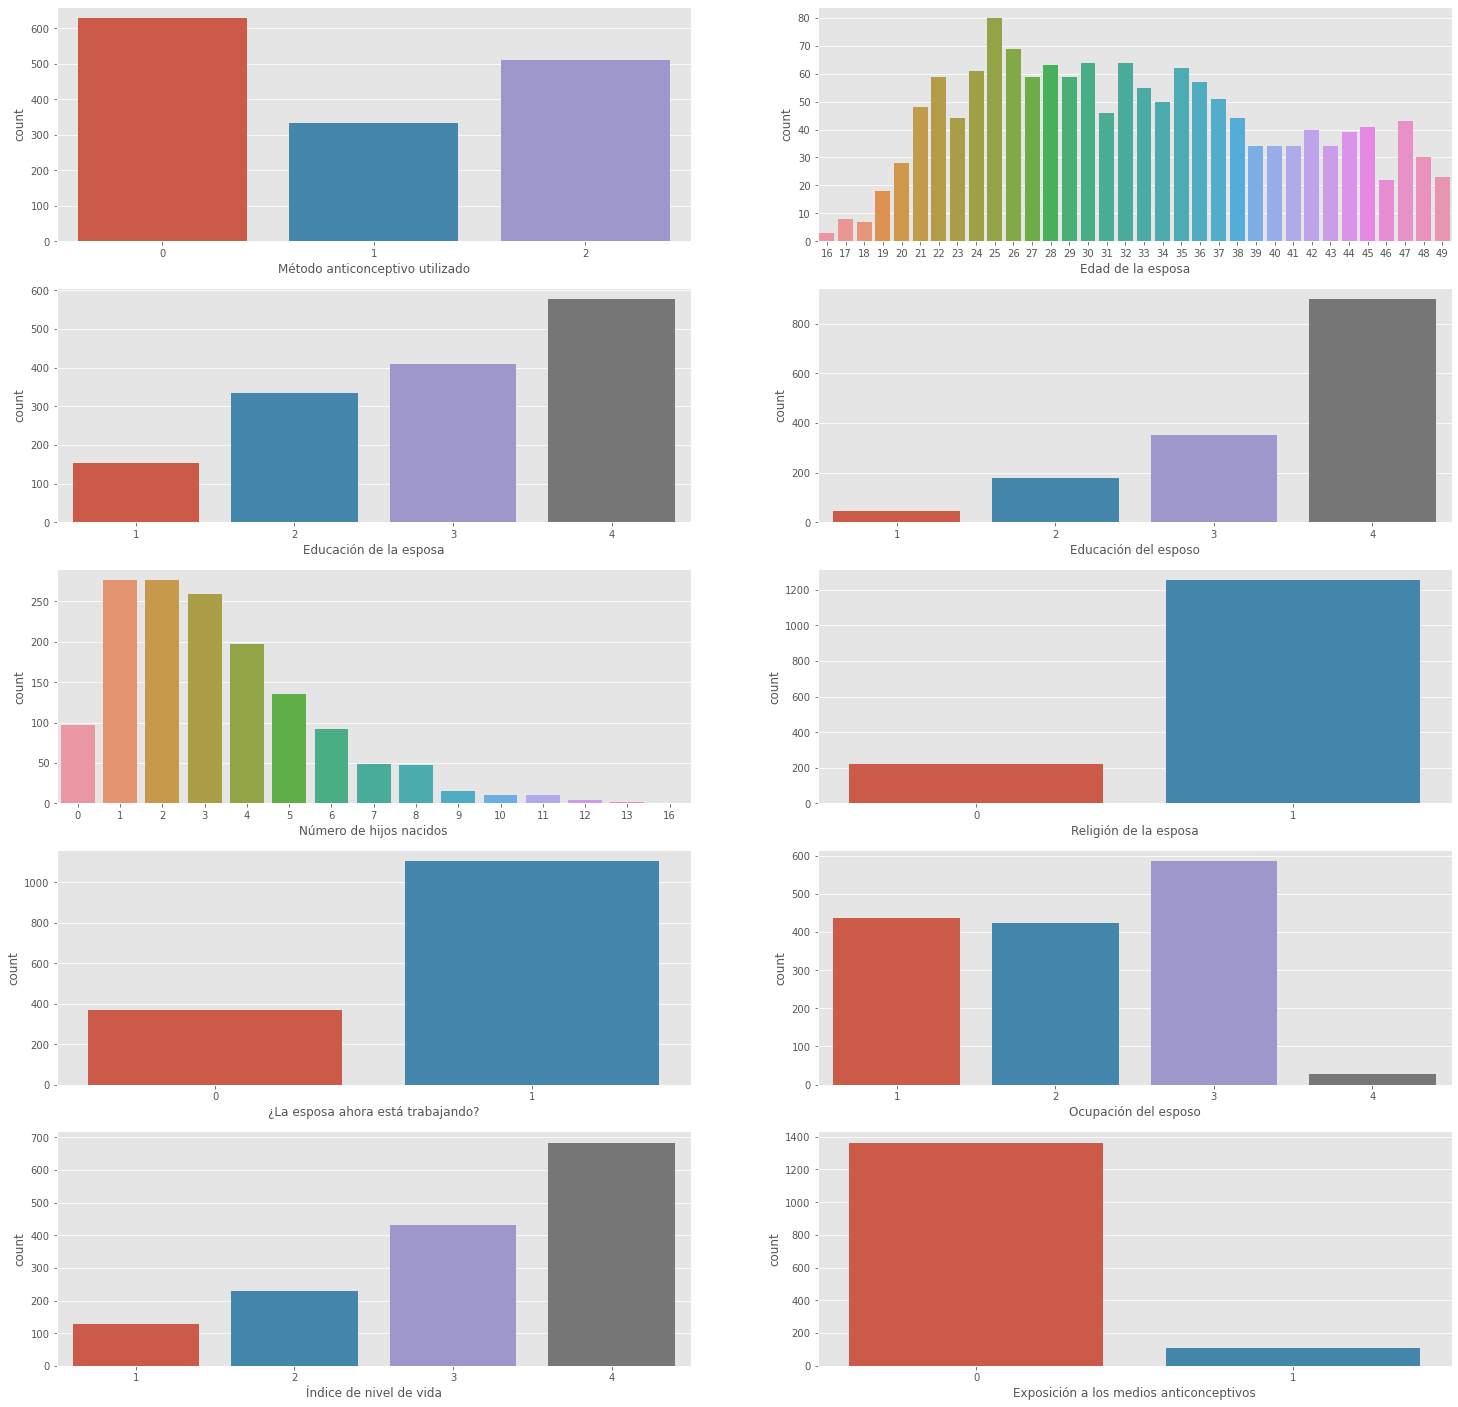

In [9]:
columns_bar= list(anticonceptivo.columns)

columns_bar_array = np.array(columns_bar)
columns_bar_array = np.reshape(columns_bar_array, (5,2))

rows = 5 ; columns = 2
f, axes = plt.subplots(rows, columns, figsize=(25,25))
print ("Diagrama de barras para todas las variables")
for row in range(rows):
    for column in range(columns):
        sb.countplot(anticonceptivo[columns_bar_array[row][column]], ax = axes[row, column])
        print('\n\n')

# Métodos para analizar correlación entre las variables

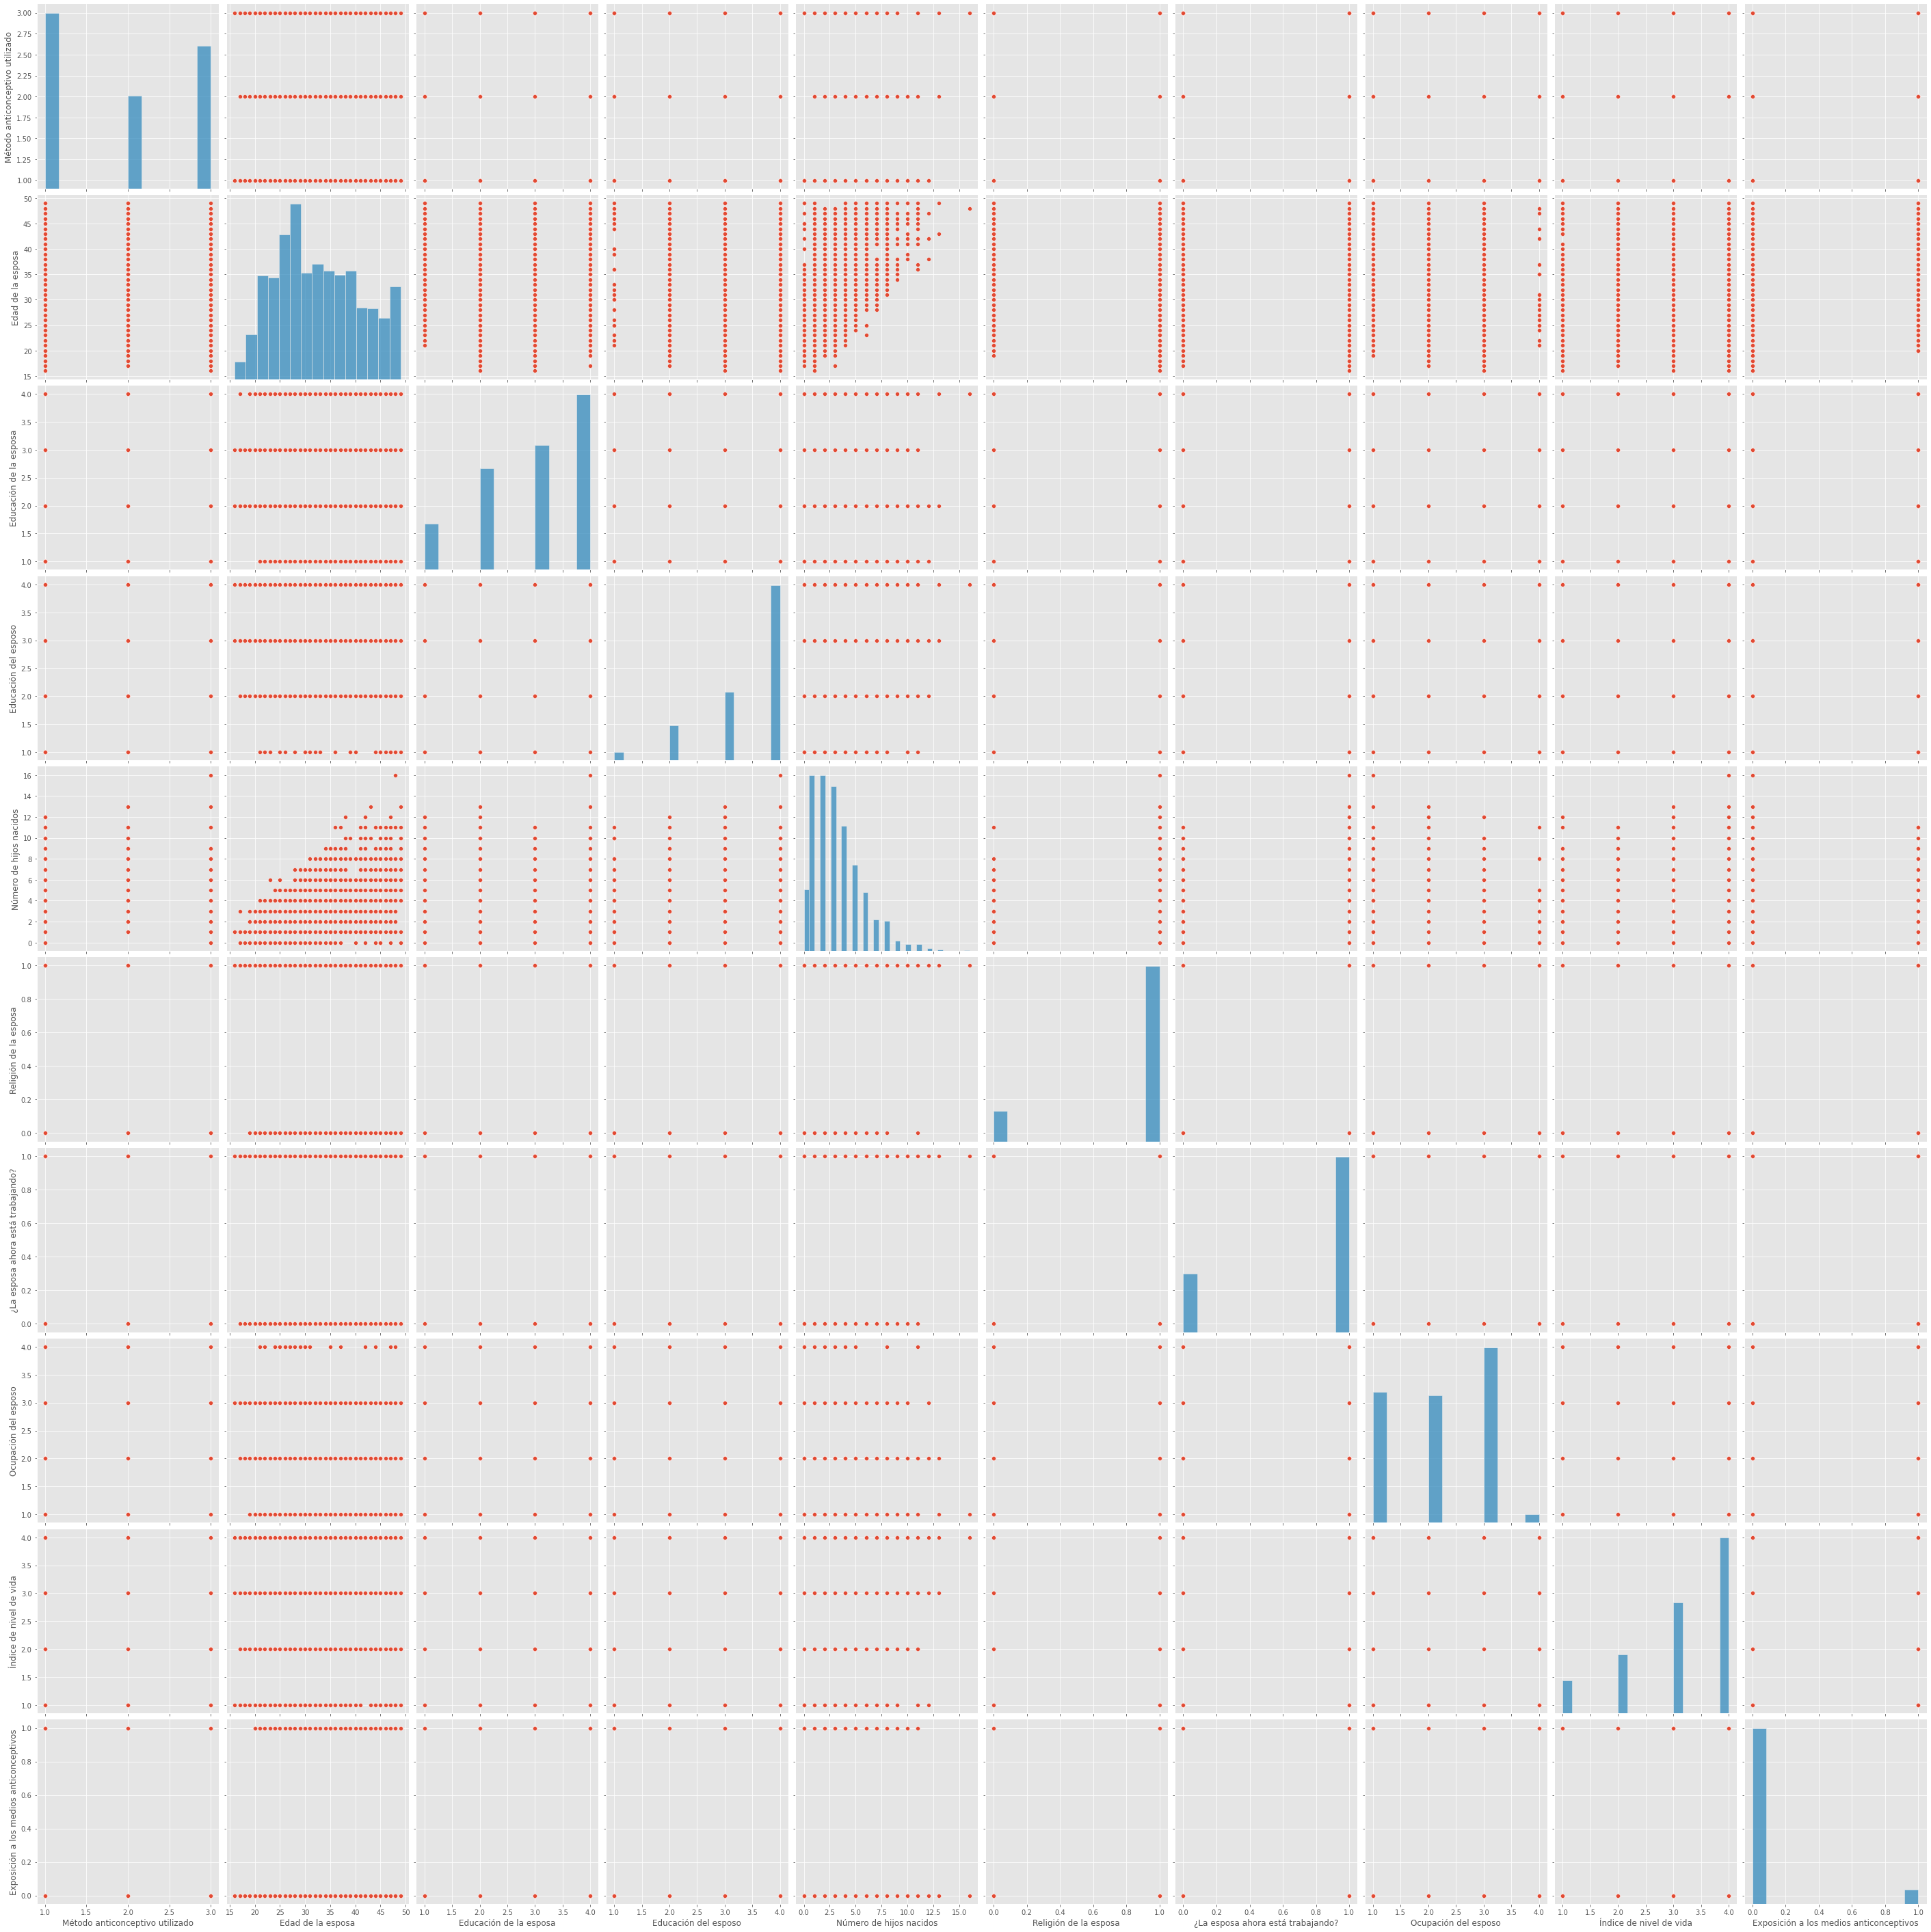

In [ ]:
sb.pairplot(anticonceptivo.dropna(), height=4,vars=["Método anticonceptivo utilizado","Edad de la esposa","Educación de la esposa","Educación del esposo",
                                                    "Número de hijos nacidos","Religión de la esposa","¿La esposa ahora está trabajando?",
                                                    "Ocupación del esposo","Índice de nivel de vida","Exposición a los medios anticonceptivos"], kind='scatter')

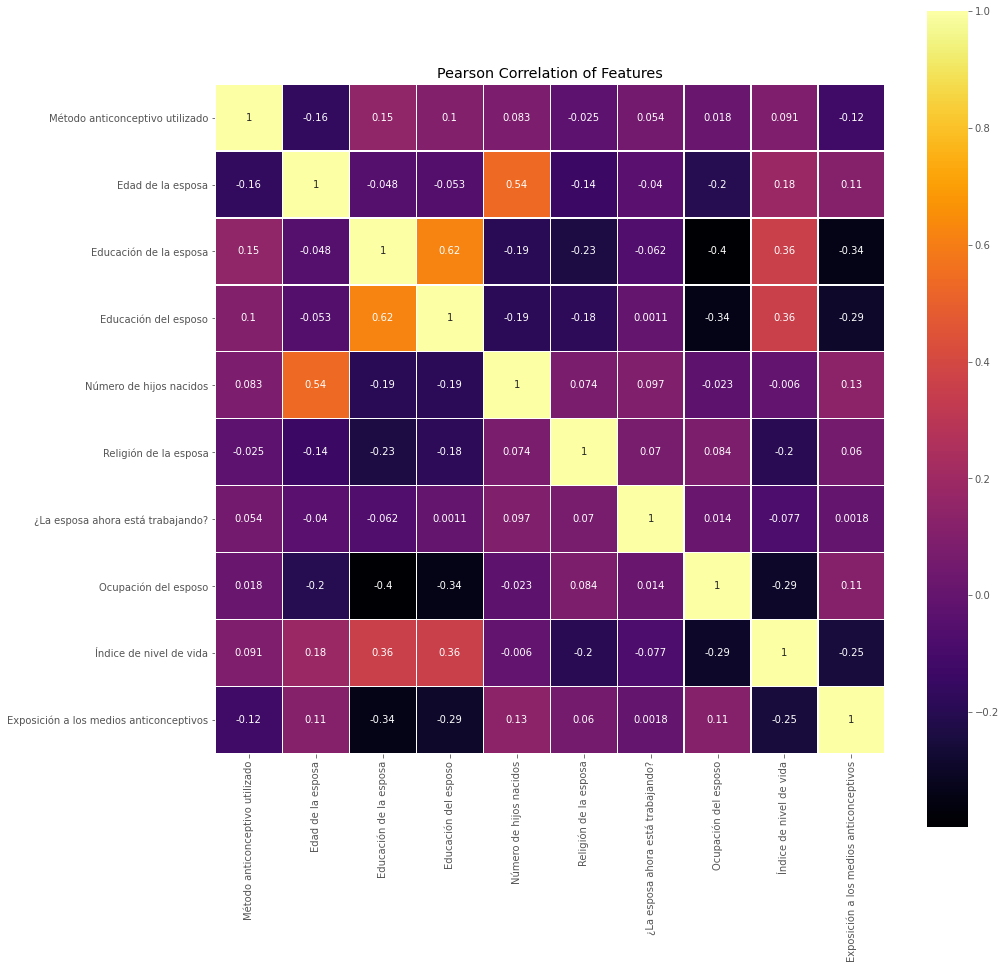

In [ ]:
colormap = plt.cm.inferno
plt.figure(figsize=(15,15))
plt.title('Pearson Correlation of Features')
sb.heatmap(anticonceptivo.astype(float).corr(),
           vmax=1.0,
           cmap=colormap,
           annot=True,
           linewidths=0.1,
           linecolor='white',
           square=True)

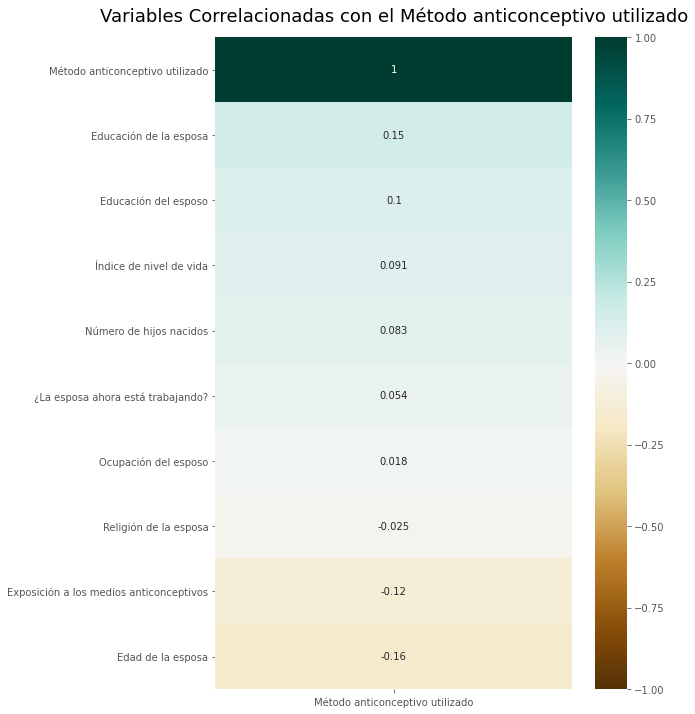

In [ ]:
plt.figure(figsize=(8, 12))

heatmap = sb.heatmap(anticonceptivo.corr()[["Método anticonceptivo utilizado"]].sort_values(by="Método anticonceptivo utilizado", ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Variables Correlacionadas con el Método anticonceptivo utilizado', fontdict={'fontsize':18}, pad=16);

# Se sospecha que a mayor nivel de educación por parte de la esposa , se recurre con mayor frecuencia a métodos anticonceptivos

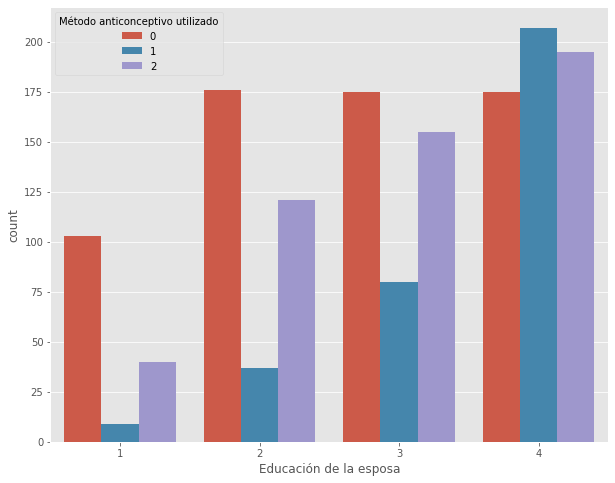

In [ ]:
plt.figure(figsize=(10, 8))
sb.countplot(x="Educación de la esposa", data=anticonceptivo, hue="Método anticonceptivo utilizado")

# Dado que la religión predominante es el Islam y una de sus creencias es el No uso de métodos anticonceptivos , entonces se analiza la relación:

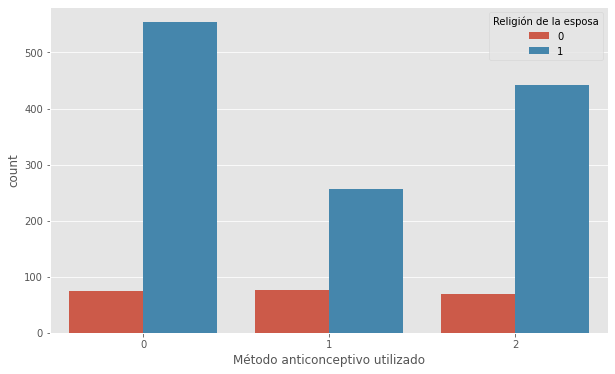

In [ ]:
plt.figure(figsize=(10, 6))
sb.countplot(x="Método anticonceptivo utilizado", data=anticonceptivo, hue="Religión de la esposa")

# Se sospecha existe correlación entre la edad de la esposa y la cantidad de hijos

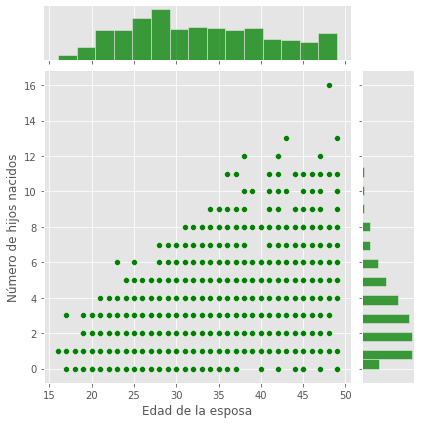

In [ ]:
sb.jointplot(x="Edad de la esposa",y="Número de hijos nacidos",data=anticonceptivo, color = 'g')

# Relación entre el índice de calidad de vida y el método anticonceptivo

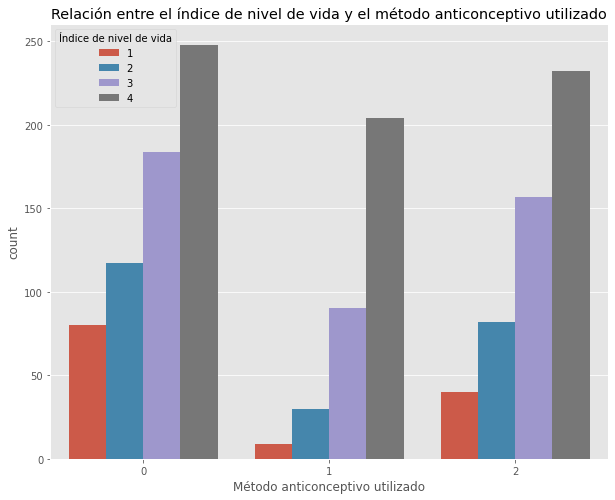

In [ ]:
plt.figure(figsize=(10,8))
plt.title('Relación entre el índice de nivel de vida y el método anticonceptivo utilizado')
sb.countplot(x="Método anticonceptivo utilizado", data=anticonceptivo, hue="Índice de nivel de vida")

# Analizar la edad de la esposa y el método anticonceptivo usado

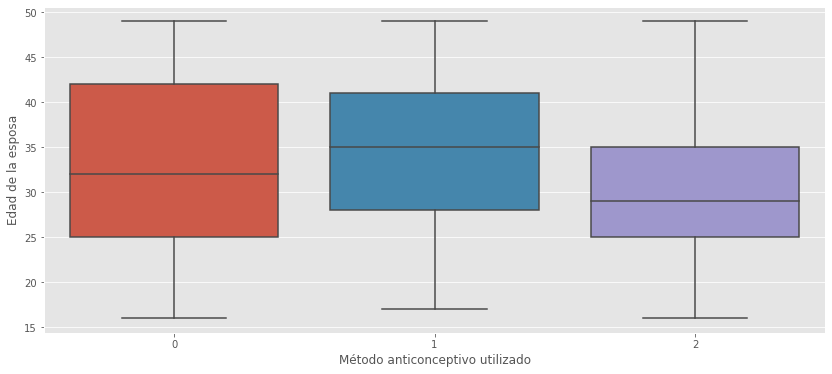

In [ ]:
plt.figure(figsize=(14,6))
sb.boxplot(x="Método anticonceptivo utilizado",y="Edad de la esposa", data=anticonceptivo)

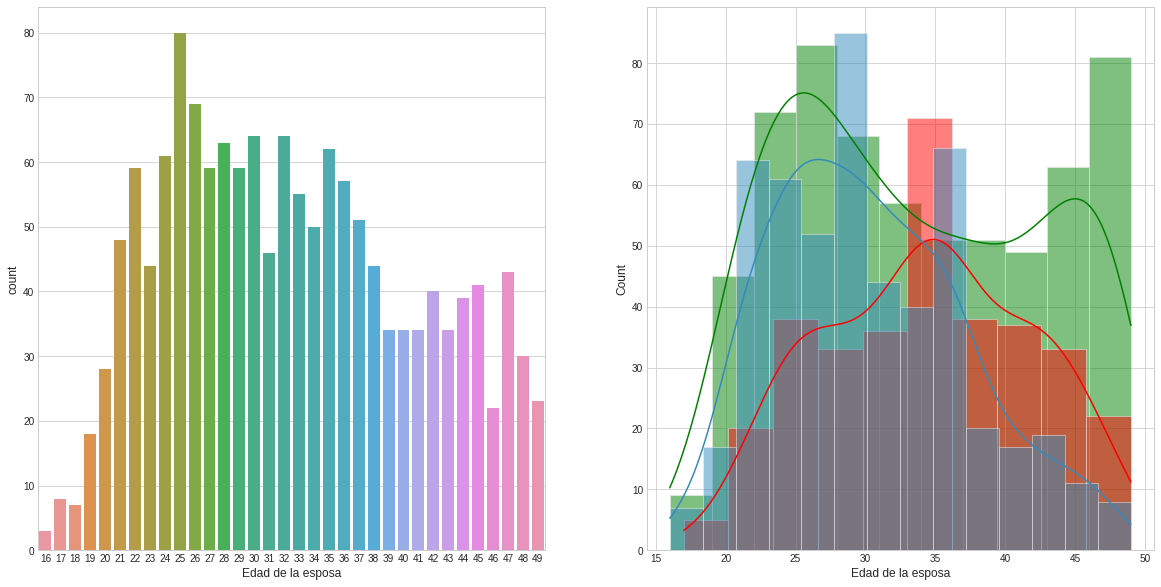

In [ ]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
sb.countplot(x="Edad de la esposa", data=anticonceptivo);
plt.subplot(1,2,2)

sb.histplot(anticonceptivo.loc[anticonceptivo["Método anticonceptivo utilizado"]== 0]["Edad de la esposa"], kde=True, color='g', legend=True)
sb.histplot(anticonceptivo.loc[anticonceptivo["Método anticonceptivo utilizado"]== 1]["Edad de la esposa"], kde=True, color='r', legend=True)
sb.histplot(anticonceptivo.loc[anticonceptivo["Método anticonceptivo utilizado"]== 2]["Edad de la esposa"], kde=True, legend=True)

# Se analiza mediante una regresión y validación cruzada para escoger el número de variables a usar

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Ranking de Variables: [1 1 1 1 1 1 1 1 1]
Número óptimo de variables: 9


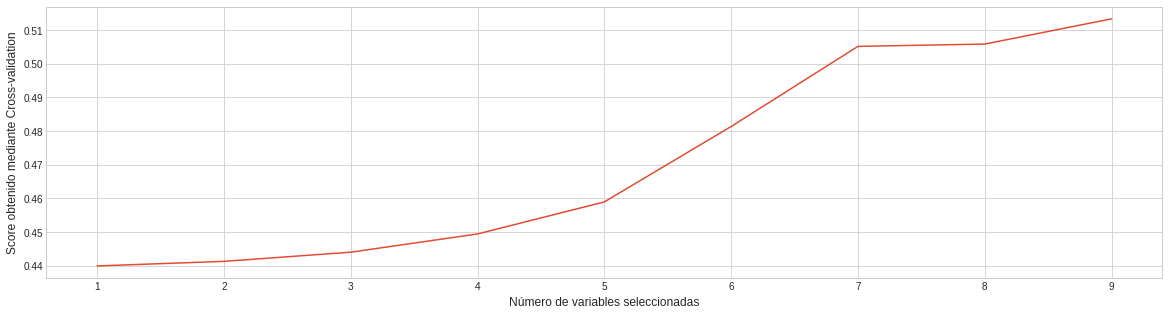

In [ ]:
# Calculamos una regresión logística para obtener la importancia de las variables
selector1 = RFECV(LogisticRegression(), step=1, cv=5, n_jobs=-1)
selector1 = selector1.fit(anticonceptivo.drop("Método anticonceptivo utilizado", axis=1).values, anticonceptivo["Método anticonceptivo utilizado"].values)
print("Ranking de Variables: %s" % selector1.ranking_)
print("Número óptimo de variables: %d" % selector1.n_features_)

# grafica de variables vs cross-validation
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(20,5))
plt.xlabel("Número de variables seleccionadas")
plt.ylabel("Score obtenido mediante Cross-validation")
plt.plot(range(1, len(selector1.grid_scores_)+1), selector1.grid_scores_);


### Se concluye entonces que es buena idea utilizar todas las variables , ya que no representan un costo computacional alto y permite obtener buenos resultados.

# Nodo raíz :

El nodo raíz se escoge teniendo en mente lo siguiente :

- La variable escogida aporta mas informacion que las demás
- Luego del arbol debemos obtener menos datos que los ingresados ( Obtener mejor información ). Esto se explica mediante ganancia de información, es decir menor entropía.


In [ ]:
cv = KFold(n_splits=5) # Numero deseado de "folds" que haremos
accuracies = list()
max_attributes = len(list(anticonceptivo))
depth_range = range(1, max_attributes + 1)


#    Usan anticonceptivo / No usan anticonceptivo =     333 * 511 / 629  = 1.34

# Testearemos la profundidad de 1 a cantidad de atributos +1
for depth in depth_range:
    fold_accuracy = []
    tree_model = tree.DecisionTreeClassifier(criterion='gini',
                                             min_samples_split=2,
                                             min_samples_leaf=17,
                                             max_depth = depth)
                                             #splitter = 'best',
                                             #class_weight=({1:1.34})) # Por defecto todas las clases igual peso
                                                                
    for train_fold, valid_fold in cv.split(anticonceptivo):
        f_train = anticonceptivo.loc[train_fold] 
        f_valid = anticonceptivo.loc[valid_fold] 

        model = tree_model.fit(X = f_train.drop(['Método anticonceptivo utilizado'], axis=1), 
                               y = f_train['Método anticonceptivo utilizado']) 
        valid_acc = model.score(X = f_valid.drop(['Método anticonceptivo utilizado'], axis=1), 
                                y = f_valid['Método anticonceptivo utilizado']) # calculamos la precision con el segmento de validacion
        fold_accuracy.append(valid_acc)

    avg = sum(fold_accuracy)/len(fold_accuracy)
    accuracies.append(avg)
    
# Mostramos los resultados obtenidos
df = pd.DataFrame({"Max Depth": depth_range, "Average Accuracy": accuracies})
df = df[["Max Depth", "Average Accuracy"]]
print(df.to_string(index=False))

 Max Depth  Average Accuracy
         1          0.159721
         2          0.245267
         3          0.293391
         4          0.403399
         5          0.449496
         6          0.399945
         7          0.365341
         8          0.381626
         9          0.386376
        10          0.387054


Se escogen 5 ramas para la profundidad del arbol, ya que obtiene el mejor valor de Accuracy



# Datos de entrenamiento y Validación

In [ ]:
print('Datos de Entrenamiento:   {} %'.format(100*len(train_fold)/anticonceptivo.shape[0]))
print('Datos de validación:    {} %'.format(100*len(valid_fold)/anticonceptivo.shape[0]))

Datos de Entrenamiento:   80.04073319755601 %
Datos de validación:    19.95926680244399 %


# Entrenar y graficar el arbol

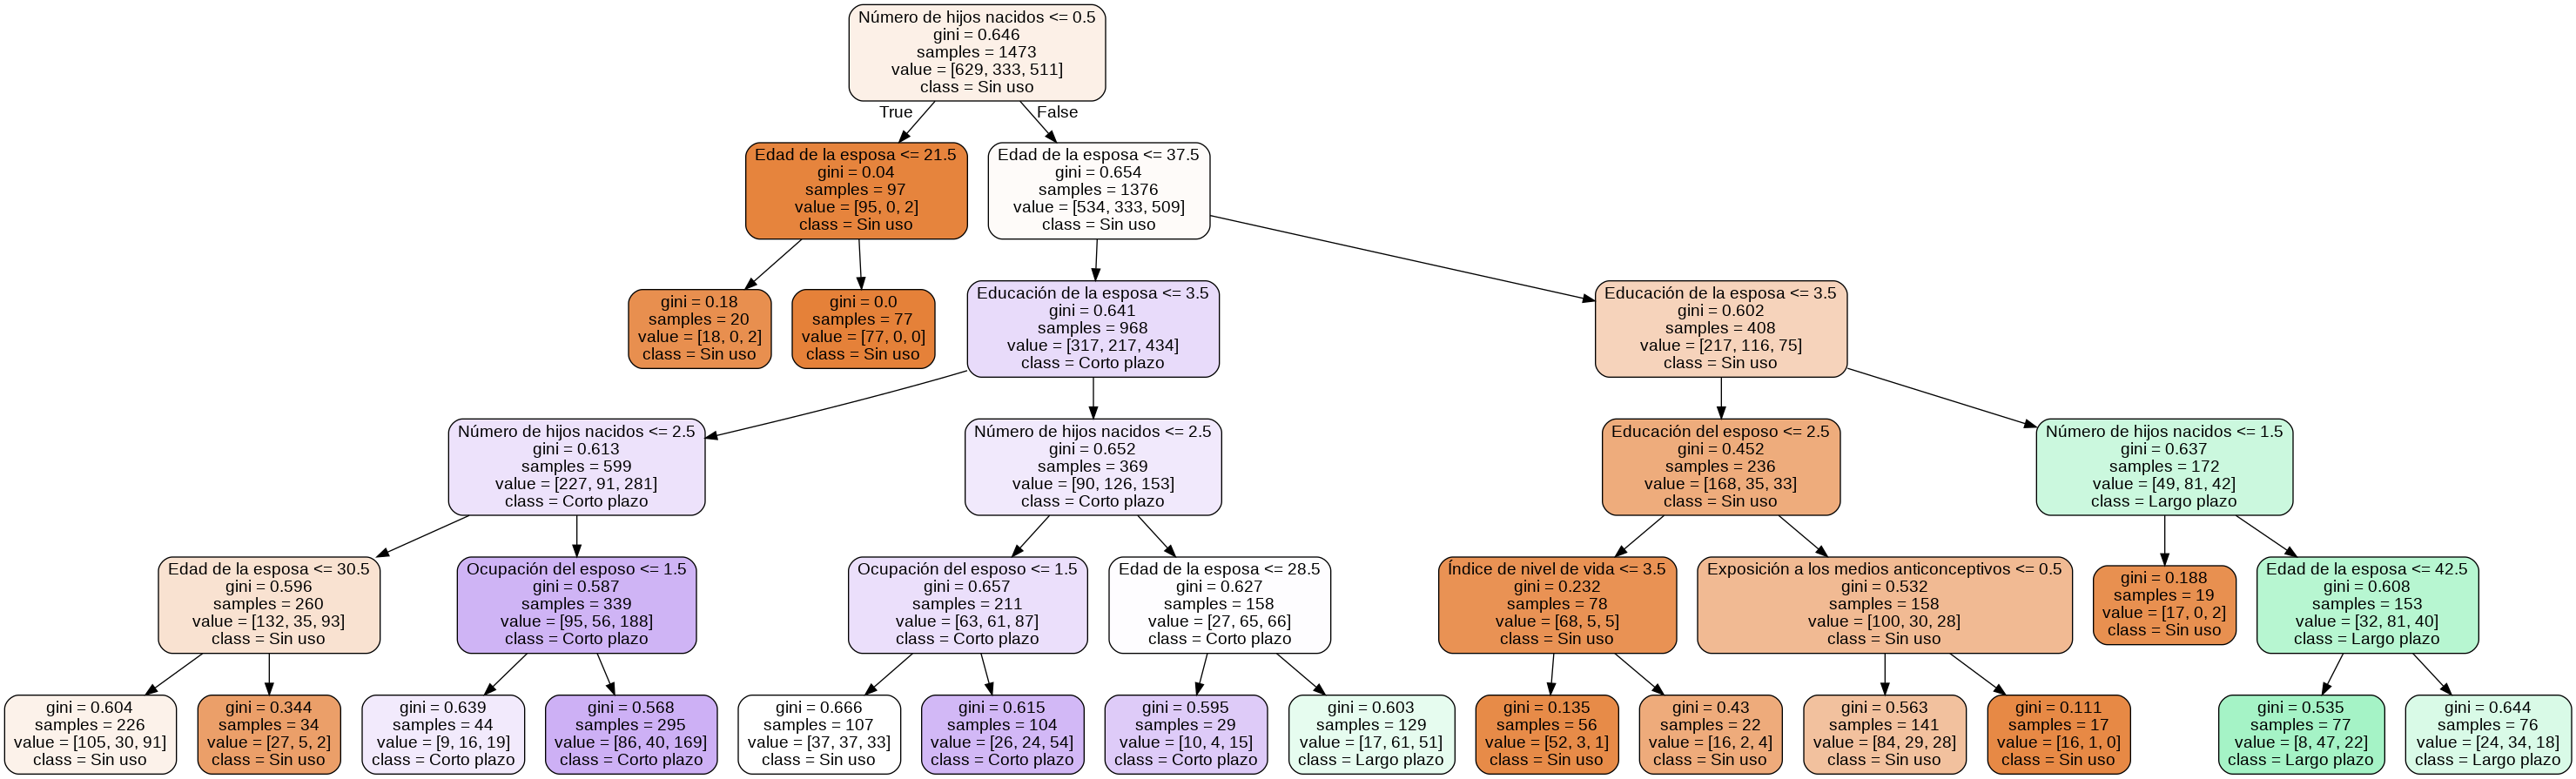

In [ ]:
# Crear arrays de entrenamiento y las etiquetas que indican el Método anticonceptivo utilizado
y_train = anticonceptivo['Método anticonceptivo utilizado']
x_train = anticonceptivo.drop(['Método anticonceptivo utilizado'], axis=1).values 



# Crear Arbol de decision con profundidad 5
decision_tree = tree.DecisionTreeClassifier(criterion='gini',                                          
                                            min_samples_split=2,
                                            min_samples_leaf=17,
                                            max_depth = 5)
                                            #class_weight={1:21.2})
decision_tree.fit(x_train, y_train)

# exportar el modelo a archivo .dot
with open(r"tree1.dot", 'w') as file:
     f = tree.export_graphviz(decision_tree,
                              out_file=file,
                              max_depth = 9,
                              impurity = True,
                              feature_names = list(anticonceptivo.drop(['Método anticonceptivo utilizado'], axis=1)),
                              class_names = ['Sin uso', 'Largo plazo', 'Corto plazo'],
                              rounded = True,
                              filled= True )
        
# Convertir el archivo .dot a png para poder visualizarlo
check_call(['dot','-Tpng',r'tree1.dot','-o',r'tree1.png'])
PImage("tree1.png")

Accuracy obtenido:

In [ ]:
acc_decision_tree = round(decision_tree.score(x_train, y_train) * 100, 2)
print(acc_decision_tree,'%')

57.57 %


# Importancia de las características


Text(0, 0.5, 'características')

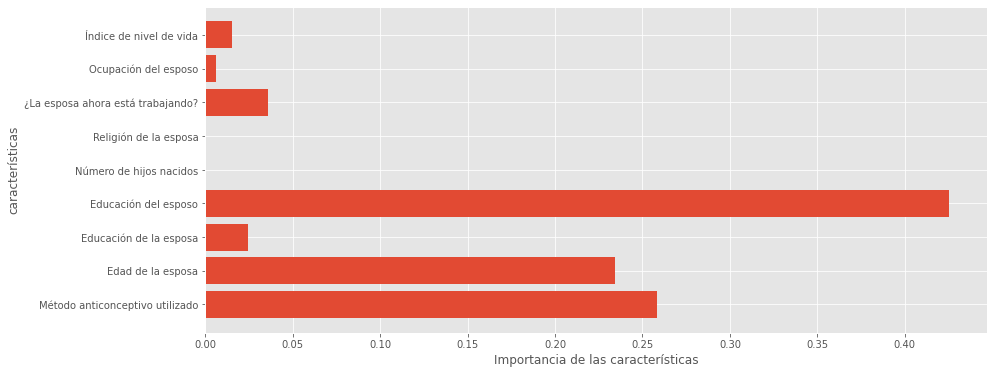

In [ ]:
caract = 9
plt.figure(figsize=(14,6))
plt.barh(range(caract), decision_tree.feature_importances_)
plt.yticks(np.arange(caract), list(anticonceptivo))
plt.xlabel('Importancia de las características')
plt.ylabel('características')

# Predicciones

In [ ]:
x_test = pd.DataFrame(columns=("Método anticonceptivo utilizado","Edad de la esposa","Educación de la esposa","Educación del esposo","Número de hijos nacidos","Religión de la esposa","¿La esposa ahora está trabajando?","Ocupación del esposo","Índice de nivel de vida","Exposición a los medios anticonceptivos"))

#x_test.loc[0] =(1,43,1,2,8,1,1,2,4,0)
#x_test.loc[0] = (2,32,4,4,4,1,1,2,3,0)
x_test.loc[0] = (3,33,4,4,2,1,0,2,4,0)

y_pred = decision_tree.predict(x_test.drop(['Método anticonceptivo utilizado'], axis = 1))
y_proba = decision_tree.predict_proba(x_test.drop(['Método anticonceptivo utilizado'], axis = 1))


print(y_proba)

print("Prediccion: " + str(y_pred+1) + "\t")
print("Probabilidad de Acierto: " + str(np.round(y_proba[0][y_pred]* 100, 2)) + "%")

[[0.25       0.23076923 0.51923077]]
Prediccion: [3]	
Probabilidad de Acierto: [51.92]%


# Clasificación mediante Gaussian Naive Bayes

In [ ]:
# Split dataset in training and test datasets
X_train, X_test = train_test_split(anticonceptivo, test_size=0.2, random_state=6) 
y_train = X_train['Método anticonceptivo utilizado']
y_test = X_test['Método anticonceptivo utilizado']

# Instantiate the classifier
gnb = GaussianNB()
# Train classifier
gnb.fit(
    X_train.drop(['Método anticonceptivo utilizado'], axis = 1).values,
    y_train
)
y_pred = gnb.predict(X_test.drop(['Método anticonceptivo utilizado'], axis = 1))
 
print('Accuracy en el set de training: {:.2f}'
     .format(gnb.score(X_train.drop(['Método anticonceptivo utilizado'], axis = 1), y_train)))
print('Accuracy en el set de test: {:.2f}'
     .format(gnb.score(X_test.drop(['Método anticonceptivo utilizado'], axis = 1), y_test)))

Accuracy en el set de training: 0.48
Accuracy en el set de test: 0.44


In [ ]:
x_test = pd.DataFrame(columns=("Método anticonceptivo utilizado","Edad de la esposa","Educación de la esposa","Educación del esposo","Número de hijos nacidos","Religión de la esposa","¿La esposa ahora está trabajando?","Ocupación del esposo","Índice de nivel de vida","Exposición a los medios anticonceptivos"))

#x_test.loc[0] =(1,43,1,2,8,1,1,2,4,0)
#x_test.loc[0] = (2,32,4,4,4,1,1,2,3,0)
x_test.loc[0] = (3,25,3,4,2,1,1,3,3,0)

y_pred = gnb.predict(x_test.drop(['Método anticonceptivo utilizado'], axis = 1))
y_proba = gnb.predict_proba(x_test.drop(['Método anticonceptivo utilizado'], axis = 1))

print(y_proba)

print("Prediccion: " + str(y_pred+1) + "\t")
print("Probabilidad de Acierto: " + str(np.round(y_proba[0][y_pred]* 100, 2)) + "%")

[[0.17187749 0.16853747 0.65958504]]
Prediccion: [3]	
Probabilidad de Acierto: [65.96]%
